In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from model import ArcFaceModel
from align import FaceAligner

root = 'E:\\localDL\\vectors'

class FaceRecognizer:
    def __init__(self, model_path='E:/localDL/models/ArcFace-Res50.h5', vector_path=root):
        self.model = ArcFaceModel(size=112, training=False)
        self.model.load_weights(model_path, by_name=True, skip_mismatch=False)
        self.vector_db = self.load_vector_db(vector_path)
        self.detector = FaceAligner(size=112)

    def load_vector_db(self, root):
        """
        ËøîÂõû dict{name: [N,512] ndarray}
        """
        db = {}
        for name in os.listdir(root):
            p_dir = os.path.join(root, name)
            if not os.path.isdir(p_dir): continue
            vecs = [np.load(os.path.join(p_dir, f))
                    for f in os.listdir(p_dir) if f.endswith(".npy")]
            if vecs:
                db[name] = np.stack(vecs, axis=0)  # (N,512)
        print(f"üìÇ Â∑≤Âä†ËΩΩ {len(db)} ‰∏™Ë∫´‰ªΩÔºåÂÖ± {sum(len(v) for v in db.values())} Êù°ÂêëÈáè")
        return db
    
    def align_face(self,img,margin=0.2,size=112):
        """
        ÂØπ‰∫∫ËÑ∏ËøõË°åÂØπÈΩê
        return: ÂØπÈΩêÂêéÁöÑ‰∫∫ËÑ∏ÂõæÂÉè
        """
        if isinstance(img,str):    
            img = cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("imgÂ∫îËØ•ÊòØÂõæÂÉèË∑ØÂæÑÊàñndarrayÁ±ªÂûã")
        
        # Ê£ÄÊµã‰∫∫ËÑ∏
        face = self.detector.align(img)
        return face
    
    def align_multi_faces(self,img,margin=0.2,size=112):
        """
        Â§ö‰∫∫ËÑ∏ËØÜÂà´ÔºåÊîØÊåÅ‰∏§ÁßçËæìÂÖ•Ê†ºÂºè: 
        strÊ†ºÂºèÁöÑÂõæÂÉèË∑ØÂæÑÔºånp.arrayÊ†ºÂºèÁöÑbgrÂõæÂÉè
        """
        if isinstance(img,str):
            img =cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("imgÂ∫îËØ•ÊòØÂõæÂÉèË∑ØÂæÑÊàñndarrayÁ±ªÂûã")
        
        faces = self.detector.align_multi_faces(img)
        return faces    # facesÁöÑËøîÂõûÂÄºÂèØËÉΩ‰∏∫noneÔºåÈúÄË¶ÅÂú®‰∏ãÊ∏∏‰ªªÂä°‰∏≠Â§ÑÁêÜnoneÁöÑÊÉÖÂÜµ
    
    def vector_extractor(self,img):
        """
        ÊèêÂèñËæìÂÖ•ÂõæÂÉèÁöÑ 512-D ÂêëÈáèÔºå‰ΩøÁî® ArcFace Ê®°Âûã„ÄÇ
        
        Args:
            img (numpy.ndarray): ËæìÂÖ•ÂõæÂÉèÊï∞ÁªÑ„ÄÇ

        Returns:
            numpy.ndarray: ÊèêÂèñÁöÑ 512-D ÂêëÈáè„ÄÇ
        """
        if img.ndim == 3:
            img = np.expand_dims(img, axis=0)
        elif img.ndim != 4 or img.shape[1:] != (112, 112, 3):
            raise ValueError(f"‚ùå ËæìÂÖ•ÂõæÂÉè shape ÈîôËØØÔºåÊî∂Âà∞ {img.shape}ÔºåÂ∫î‰∏∫ (112,112,3) Êàñ (N,112,112,3)")
        vector = self.model.predict(img)
        return vector
    
    def recognize(self,img,aligned=False,thresh=0.5):
        """
        ËØÜÂà´ÂõæÂÉè‰∏≠ÁöÑ‰∫∫ËÑ∏Âπ∂ËøîÂõûÂåπÈÖçÁöÑË∫´‰ªΩÂêçÁß∞ÂíåÁõ∏‰ººÂ∫¶
        :param img: ËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÊàñÂõæÂÉèÊï∞ÁªÑ
        :return: (name, similarity) Êàñ None
        """
        face_rgb = img
        if aligned == False:    #Â¶ÇÊûú‰º†ÂÖ•ÁöÑÂõæÂÉè‰∏çÊòØÈ¢ÑÂÖàÂ§ÑÁêÜÂ•ΩÁöÑ‰∫∫ËÑ∏
            face_rgb = self.align_face(face_rgb)
        
        if face_rgb is None:
            print("Ê≤°ÊúâÊâæÂà∞‰∫∫ËÑ∏")
            return None
        
        vector = self.vector_extractor(face_rgb)
        
    # ‰∏ãÈù¢ÁöÑËÆ°ÁÆóÈÄªËæëÂæÖÊîπÂÜô
        best_name, best_similarity = None, -1
        for name, vectors in self.vector_db.items():
            mean_similarity = cosine_sim(vector, vectors[0])
            if mean_similarity>best_similarity: # ÂÖàÂØπÂπ≥ÂùáÂÄºËøõË°åÂåπÈÖçÔºå
                best_similarity = mean_similarity
                best_name = name
            
        if best_similarity>0.45:
            print(f"ËØÜÂà´ÁªìÊûúÊòØ{best_name},{float(best_similarity)}")
            return best_name, float(best_similarity)

        best_name, best_sim = None, -1.0
        for name, vectors in self.vector_db.items():
            for v in vectors:                          # Âê´ÂùáÂÄºÊàñÂèØË∑≥Ëøá [0]
                sim = cosine_sim(vector, v)
                if sim > best_sim:
                    best_name, best_sim = name, sim

        if best_sim < thresh:
            best_name = "unknown"
            best_sim = -1
            
        print(f"ËØÜÂà´ÁªìÊûúÊòØ{best_name},{float(best_sim)}")
        return best_name, float(best_sim)
    
    def recognize_multi(self, img):
        """
        ÊâπÈáèËØÜÂà´Â§öÂº†ÂõæÂÉè‰∏≠ÁöÑ‰∫∫ËÑ∏ÔºåËøîÂõûËØÜÂà´ÁªìÊûúÂàóË°®
        :param imgs: ËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÂàóË°®ÊàñÂõæÂÉèÊï∞ÁªÑÂàóË°®
        :return: ÁªìÊûúÂàóË°®ÔºåÊØè‰∏™ÂÖÉÁ¥†‰∏∫ (name, similarity) Êàñ None
        """
        results = []
        faces = self.detector.align_multi_faces(img)
        
        for face in faces:
            try:
                # Â∞ùËØïËØÜÂà´ÂçïÂº†ÂõæÂÉè
                # facesÊòØÁªèËøáÂ§ÑÁêÜÁöÑ‰∫∫ËÑ∏ÈõÜ
                result = self.recognize(face,aligned=True)
                results.append(result)
            except Exception as e:
                # ÊçïËé∑Âπ∂ËÆ∞ÂΩïÂºÇÂ∏∏ÔºåÂêåÊó∂Ê∑ªÂä†NoneË°®Á§∫ËØÜÂà´Â§±Ë¥•
                print(f"ËØÜÂà´ÂõæÂÉèÊó∂Âá∫Èîô: {str(e)}")
                results.append(None)

        print(results)
        
        return results
    
    def saveVector(self,root,name,vector):
        """
        ‰øùÂ≠òÂçï‰∏™ÂêëÈáè
        """
        # 1 Á°ÆËÆ§ÂêëÈáèÊ†ºÂºèÊ≠£Á°Æ
        vec  = np.array(vector, dtype=np.float32).reshape(-1)
        if vec.ndim != 1 or vec.shape[0] != 512:
            raise ValueError(f"‚ùå ÂêëÈáèÊ†ºÂºèÈîôËØØÔºåÊî∂Âà∞ {vec.shape}ÔºåÂ∫î‰∏∫ (512,)")
        
        # 2 ÂàõÂª∫‰∫∫Áâ©Êñá‰ª∂Â§π
        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # 3 ÁîüÊàêÂîØ‰∏ÄÊñá‰ª∂Âêç
        file_name = f"{name}_{len(os.listdir(person_dir)) + 1}.npy" # Â∞ÜÁºñÂè∑0ÁïôÂá∫Êù•Áî®‰∫éÊîæÁΩÆÂπ≥ÂùáÂêëÈáè
        file_path = os.path.join(person_dir, file_name)

        # 4 ‰øùÂ≠òÂêëÈáè
        np.save(file_path, vec)
        print(f"‚úÖ ÂêëÈáèÂ∑≤‰øùÂ≠òÂà∞ {file_path}")
        self.flash_db()  # Âà∑Êñ∞Êï∞ÊçÆÂ∫ì
        return file_path
    
    def compute_mean_vector(self,name,db):
        """
        ËÆ°ÁÆóÊåáÂÆöË∫´‰ªΩÁöÑÂπ≥ÂùáÂêëÈáè
        :param name: Ë∫´‰ªΩÂêçÁß∞
        :param db: ÂêëÈáèÊï∞ÊçÆÂ∫ì
        :return: Âπ≥ÂùáÂêëÈáè
        """
        if name not in db or len(db[name]) == 0:
            raise ValueError(f"Êú™ÊâæÂà∞ {name} ÁöÑÂêëÈáèÊï∞ÊçÆ")

        vecs = db[name]

        # Ëã•ÊãÖÂøÉÂéÜÂè≤ÂêëÈáèÊú™ÂΩí‰∏ÄÂåñÔºåÂèØÂú®ËøôÈáåÂÜç‰øùÈô© L2 normalize ‰∏ÄÊ¨°
        vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

        mean_vec = vecs.mean(axis=0)
        mean_vec /= np.linalg.norm(mean_vec)             # ÂÜçÂΩí‰∏ÄÂåñÔºå‰øùÊåÅÊ®°Èïø = 1

        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # ÁîüÊàêÂîØ‰∏ÄÊñá‰ª∂Âêç
        file_name = f"{name}_0.npy"
        file_path = os.path.join(person_dir, file_name)

        # ‰øùÂ≠òÂêëÈáè
        np.save(file_path, mean_vec)
        print(f"‚úÖ Âπ≥ÂùáÂêëÈáèÂ∑≤‰øùÂ≠òÂà∞ {file_path}")
        self.flash_db()

        return mean_vec
    
    def flash_db(self):
        """
        Âà∑Êñ∞ÂêëÈáèÊï∞ÊçÆÂ∫ìÔºåÈáçÊñ∞Âä†ËΩΩÊâÄÊúâÂêëÈáè
        """
        self.vector_db = self.load_vector_db(root)
        print("‚úÖ ÂêëÈáèÊï∞ÊçÆÂ∫ìÂ∑≤Âà∑Êñ∞")

    def register(self, img, name):
        """
        Ê≥®ÂÜåÊñ∞Ë∫´‰ªΩÔºåÊèêÂèñÂêëÈáèÂπ∂‰øùÂ≠ò
        :param img: ËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÊàñÂõæÂÉèÊï∞ÁªÑ
        :param name: Ë∫´‰ªΩÂêçÁß∞
        """
        face_rgb = self.align_face(img)
        if face_rgb is None:
            raise ValueError("Êú™Ê£ÄÊµãÂà∞‰∫∫ËÑ∏ÔºåËØ∑Ê£ÄÊü•ËæìÂÖ•ÂõæÂÉè")

        vector = self.vector_extractor(face_rgb)
        self.saveVector(root, name, vector)
        self.compute_mean_vector(name, self.vector_db)
    



























def cosine_sim(a,b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import os
    import sys
    
    sys.path.append('E:/localDL/faceai/engine')

    img_path = 'E:/localDL/wubai1.png'
    bgr = cv2.imread(img_path)
    
    # ÂàõÂª∫ÂØπÈΩêÂô®
    aligner = FaceAligner(size=112)
    Recognizer = FaceRecognizer()
    
    # Ëé∑ÂèñÊâÄÊúâ‰∫∫ËÑ∏ÂØπÈΩêÁªìÊûú
    aligned_faces = Recognizer.align_multi_faces(img_path)
    reco_results = Recognizer.recognize_multi(img_path)
    print(f"ËØÜÂà´ÁöÑÁªìÊûúÈõÜÊòØÔºö{reco_results}")




    
    if not aligned_faces:
        print("Êú™Ê£ÄÊµãÂà∞‰ªª‰Ωï‰∫∫ËÑ∏")
        exit()
    
    # ÂàõÂª∫ÂõæÂÉèÊòæÁ§∫Â∏ÉÂ±Ä
    n_faces = len(aligned_faces)
    fig, axs = plt.subplots(1, n_faces + 1, figsize=(4*(n_faces+1), 4))
    
    # ÊòæÁ§∫ÂéüÂßãÂõæÂÉèÔºàÂ∏¶‰∫∫ËÑ∏Ê°ÜÔºâ
    img_with_boxes = bgr.copy()
    faces = aligner.app.get(bgr)  # Ëé∑Âèñ‰∫∫ËÑ∏Ê£ÄÊµãÁªìÊûú
    
    for face in faces:
        # ÁªòÂà∂‰∫∫ËÑ∏Ê°Ü
        bbox = face.bbox.astype(int)
        cv2.rectangle(img_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
        # ÁªòÂà∂ÂÖ≥ÈîÆÁÇπ
        for kp in face.kps:
            cv2.circle(img_with_boxes, (int(kp[0]), int(kp[1])), 3, (0, 0, 255), -1)
        
        # Ê∑ªÂä†ÁΩÆ‰ø°Â∫¶Ê†áÁ≠æ
        cv2.putText(img_with_boxes, f"{face.det_score:.2f}", (bbox[0], bbox[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # ÊòæÁ§∫ÂéüÂßãÂõæÂÉè
    rgb_original = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    axs[0].imshow(rgb_original)
    axs[0].set_title(f"Original ({len(faces)} faces)")
    axs[0].axis("off")
    
    # ÊòæÁ§∫ÊâÄÊúâÂØπÈΩêÂêéÁöÑ‰∫∫ËÑ∏
    for i, aligned_face in enumerate(aligned_faces):
        # ËΩ¨Êç¢‰∏∫RGBÊ†ºÂºèÁî®‰∫éÊòæÁ§∫
        rgb_aligned = cv2.cvtColor((aligned_face*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        # ÊòæÁ§∫ÂØπÈΩêÂêéÁöÑ‰∫∫ËÑ∏
        axs[i+1].imshow(rgb_aligned)
        axs[i+1].set_title(f"Name {reco_results[i][0]}")
        axs[i+1].axis("off")
    
    plt.tight_layout()
    plt.show()

d:\anaconda\envs\tf_cpu\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:999: The handshake operation timed out>
  data = fetch_version_info()


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\susan/.insightface\models\buffalo_1\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'

AttributeError: 'str' object has no attribute 'shape'

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1', 'sdpa_kernel': '0', 'fuse_conv_bias': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\susan/.insightface\models\buffalo_1\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'

<ipython-input-2-86ad559ae0fb>:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"ËØÜÂà´ÁªìÊûúÊòØ{best_name},{float(best_sim)}")
<ipython-input-2-86ad559ae0fb>:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return best_name, float(best_sim)


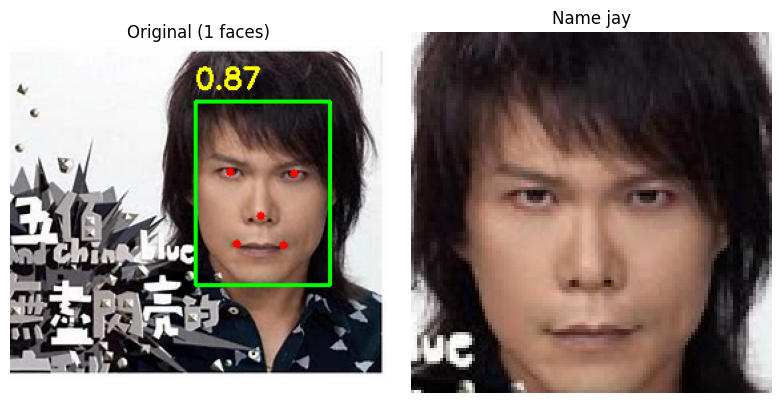

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from model import ArcFaceModel
from align import FaceAligner

root = 'E:\\localDL\\vectors'

class FaceRecognizer:
    def __init__(self, model_path='E:/localDL/models/ArcFace-Res50.h5', vector_path=root):
        self.model = ArcFaceModel(size=112, training=False)
        self.model.load_weights(model_path, by_name=True, skip_mismatch=False)
        self.vector_db = self.load_vector_db(vector_path)
        self.detector = FaceAligner(size=112)

    def load_vector_db(self, root):
        """
        ËøîÂõû dict{name: [N,512] ndarray}
        """
        db = {}
        for name in os.listdir(root):
            p_dir = os.path.join(root, name)
            if not os.path.isdir(p_dir): continue
            vecs = [np.load(os.path.join(p_dir, f))
                    for f in os.listdir(p_dir) if f.endswith(".npy")]
            if vecs:
                db[name] = np.stack(vecs, axis=0)  # (N,512)
        print(f"üìÇ Â∑≤Âä†ËΩΩ {len(db)} ‰∏™Ë∫´‰ªΩÔºåÂÖ± {sum(len(v) for v in db.values())} Êù°ÂêëÈáè")
        return db
    
    def align_face(self,img,margin=0.2,size=112):
        """
        ÂØπ‰∫∫ËÑ∏ËøõË°åÂØπÈΩê
        return: ÂØπÈΩêÂêéÁöÑ‰∫∫ËÑ∏ÂõæÂÉè
        """
        if isinstance(img,str):    
            img = cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("imgÂ∫îËØ•ÊòØÂõæÂÉèË∑ØÂæÑÊàñndarrayÁ±ªÂûã")
        
        # Ê£ÄÊµã‰∫∫ËÑ∏
        face = self.detector.align(img)
        return face
    
    def align_multi_faces(self,img,margin=0.2,size=112):
        """
        Â§ö‰∫∫ËÑ∏ËØÜÂà´ÔºåÊîØÊåÅ‰∏§ÁßçËæìÂÖ•Ê†ºÂºè: 
        strÊ†ºÂºèÁöÑÂõæÂÉèË∑ØÂæÑÔºånp.arrayÊ†ºÂºèÁöÑbgrÂõæÂÉè
        """
        if isinstance(img,str):
            img =cv2.imread(img)

        if not isinstance(img,np.ndarray):
            raise ValueError("imgÂ∫îËØ•ÊòØÂõæÂÉèË∑ØÂæÑÊàñndarrayÁ±ªÂûã")
        
        faces = self.detector.align_multi_faces(img)
        return faces    # facesÁöÑËøîÂõûÂÄºÂèØËÉΩ‰∏∫noneÔºåÈúÄË¶ÅÂú®‰∏ãÊ∏∏‰ªªÂä°‰∏≠Â§ÑÁêÜnoneÁöÑÊÉÖÂÜµ
    
    def vector_extractor(self,img):
        """
        ÊèêÂèñËæìÂÖ•ÂõæÂÉèÁöÑ 512-D ÂêëÈáèÔºå‰ΩøÁî® ArcFace Ê®°Âûã„ÄÇ
        
        Args:
            img (numpy.ndarray): ËæìÂÖ•ÂõæÂÉèÊï∞ÁªÑ„ÄÇ

        Returns:
            numpy.ndarray: ÊèêÂèñÁöÑ 512-D ÂêëÈáè„ÄÇ
        """
        if img.ndim == 3:
            img = np.expand_dims(img, axis=0)
        elif img.ndim != 4 or img.shape[1:] != (112, 112, 3):
            raise ValueError(f"‚ùå ËæìÂÖ•ÂõæÂÉè shape ÈîôËØØÔºåÊî∂Âà∞ {img.shape}ÔºåÂ∫î‰∏∫ (112,112,3) Êàñ (N,112,112,3)")
        vector = self.model.predict(img)
        return vector
    
    def recognize(self,img,aligned=False):
        """
        ËØÜÂà´ÂõæÂÉè‰∏≠ÁöÑ‰∫∫ËÑ∏Âπ∂ËøîÂõûÂåπÈÖçÁöÑË∫´‰ªΩÂêçÁß∞ÂíåÁõ∏‰ººÂ∫¶
        :param img: ËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÊàñÂõæÂÉèÊï∞ÁªÑ
        :return: (name, similarity) Êàñ None
        """
        face_rgb = img
        if aligned == False:    #Â¶ÇÊûú‰º†ÂÖ•ÁöÑÂõæÂÉè‰∏çÊòØÈ¢ÑÂÖàÂ§ÑÁêÜÂ•ΩÁöÑ‰∫∫ËÑ∏
            face_rgb = self.align_face(face_rgb)
        
        if face_rgb is None:
            print("Ê≤°ÊúâÊâæÂà∞‰∫∫ËÑ∏")
            return None
        
        vector = self.vector_extractor(face_rgb)
        
    # ‰∏ãÈù¢ÁöÑËÆ°ÁÆóÈÄªËæëÂæÖÊîπÂÜô
        best_name, best_similarity = None, -1
        for name, vectors in self.vector_db.items():
            mean_similarity = cosine_sim(vector, vectors[0])
            if mean_similarity>best_similarity: # ÂÖàÂØπÂπ≥ÂùáÂÄºËøõË°åÂåπÈÖçÔºå
                best_similarity = mean_similarity
                best_name = name
            
        if best_similarity>0.45:
            print(f"ËØÜÂà´ÁªìÊûúÊòØ{best_name},{float(best_similarity)}")
            return best_name, float(best_similarity)

        best_name, best_sim = None, -1.0
        for name, vectors in self.vector_db.items():
            for v in vectors:                          # Âê´ÂùáÂÄºÊàñÂèØË∑≥Ëøá [0]
                sim = cosine_sim(vector, v)
                if sim > best_sim:
                    best_name, best_sim = name, sim
        print(f"ËØÜÂà´ÁªìÊûúÊòØ{best_name},{float(best_sim)}")
        return best_name, float(best_sim)
    
    def recognize_multi(self, img):
        """
        ÊâπÈáèËØÜÂà´Â§öÂº†ÂõæÂÉè‰∏≠ÁöÑ‰∫∫ËÑ∏ÔºåËøîÂõûËØÜÂà´ÁªìÊûúÂàóË°®
        :param imgs: ËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÂàóË°®ÊàñÂõæÂÉèÊï∞ÁªÑÂàóË°®
        :return: ÁªìÊûúÂàóË°®ÔºåÊØè‰∏™ÂÖÉÁ¥†‰∏∫ (name, similarity) Êàñ None
        """
        results = []
        faces = self.align_multi_faces(img)
        
        for face in faces:
            try:
                # Â∞ùËØïËØÜÂà´ÂçïÂº†ÂõæÂÉè
                # facesÊòØÁªèËøáÂ§ÑÁêÜÁöÑ‰∫∫ËÑ∏ÈõÜ
                result = self.recognize(face,aligned=True)
                results.append(result)
            except Exception as e:
                # ÊçïËé∑Âπ∂ËÆ∞ÂΩïÂºÇÂ∏∏ÔºåÂêåÊó∂Ê∑ªÂä†NoneË°®Á§∫ËØÜÂà´Â§±Ë¥•
                print(f"ËØÜÂà´ÂõæÂÉèÊó∂Âá∫Èîô: {str(e)}")
                results.append(None)

        print(results)
        
        return results
    
    def saveVector(self,root,name,vector):
        """
        ‰øùÂ≠òÂçï‰∏™ÂêëÈáè
        """
        # 1 Á°ÆËÆ§ÂêëÈáèÊ†ºÂºèÊ≠£Á°Æ
        vec  = np.array(vector, dtype=np.float32).reshape(-1)
        if vec.ndim != 1 or vec.shape[0] != 512:
            raise ValueError(f"‚ùå ÂêëÈáèÊ†ºÂºèÈîôËØØÔºåÊî∂Âà∞ {vec.shape}ÔºåÂ∫î‰∏∫ (512,)")
        
        # 2 ÂàõÂª∫‰∫∫Áâ©Êñá‰ª∂Â§π
        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # 3 ÁîüÊàêÂîØ‰∏ÄÊñá‰ª∂Âêç
        file_name = f"{name}_{len(os.listdir(person_dir)) + 1}.npy" # Â∞ÜÁºñÂè∑0ÁïôÂá∫Êù•Áî®‰∫éÊîæÁΩÆÂπ≥ÂùáÂêëÈáè
        file_path = os.path.join(person_dir, file_name)

        # 4 ‰øùÂ≠òÂêëÈáè
        np.save(file_path, vec)
        print(f"‚úÖ ÂêëÈáèÂ∑≤‰øùÂ≠òÂà∞ {file_path}")
        self.flash_db()  # Âà∑Êñ∞Êï∞ÊçÆÂ∫ì
        return file_path
    
    def compute_mean_vector(self,name,db):
        """
        ËÆ°ÁÆóÊåáÂÆöË∫´‰ªΩÁöÑÂπ≥ÂùáÂêëÈáè
        :param name: Ë∫´‰ªΩÂêçÁß∞
        :param db: ÂêëÈáèÊï∞ÊçÆÂ∫ì
        :return: Âπ≥ÂùáÂêëÈáè
        """
        if name not in db or len(db[name]) == 0:
            raise ValueError(f"Êú™ÊâæÂà∞ {name} ÁöÑÂêëÈáèÊï∞ÊçÆ")

        vecs = db[name]

        # Ëã•ÊãÖÂøÉÂéÜÂè≤ÂêëÈáèÊú™ÂΩí‰∏ÄÂåñÔºåÂèØÂú®ËøôÈáåÂÜç‰øùÈô© L2 normalize ‰∏ÄÊ¨°
        vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

        mean_vec = vecs.mean(axis=0)
        mean_vec /= np.linalg.norm(mean_vec)             # ÂÜçÂΩí‰∏ÄÂåñÔºå‰øùÊåÅÊ®°Èïø = 1

        person_dir = os.path.join(root, name)
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        # ÁîüÊàêÂîØ‰∏ÄÊñá‰ª∂Âêç
        file_name = f"{name}_0.npy"
        file_path = os.path.join(person_dir, file_name)

        # ‰øùÂ≠òÂêëÈáè
        np.save(file_path, mean_vec)
        print(f"‚úÖ Âπ≥ÂùáÂêëÈáèÂ∑≤‰øùÂ≠òÂà∞ {file_path}")
        self.flash_db()

        return mean_vec
    
    def flash_db(self):
        """
        Âà∑Êñ∞ÂêëÈáèÊï∞ÊçÆÂ∫ìÔºåÈáçÊñ∞Âä†ËΩΩÊâÄÊúâÂêëÈáè
        """
        self.vector_db = self.load_vector_db(root)
        print("‚úÖ ÂêëÈáèÊï∞ÊçÆÂ∫ìÂ∑≤Âà∑Êñ∞")

    def register(self, img, name):
        """
        Ê≥®ÂÜåÊñ∞Ë∫´‰ªΩÔºåÊèêÂèñÂêëÈáèÂπ∂‰øùÂ≠ò
        :param img: ËæìÂÖ•ÂõæÂÉèË∑ØÂæÑÊàñÂõæÂÉèÊï∞ÁªÑ
        :param name: Ë∫´‰ªΩÂêçÁß∞
        """
        face_rgb = self.align_face(img)
        if face_rgb is None:
            raise ValueError("Êú™Ê£ÄÊµãÂà∞‰∫∫ËÑ∏ÔºåËØ∑Ê£ÄÊü•ËæìÂÖ•ÂõæÂÉè")

        vector = self.vector_extractor(face_rgb)
        self.saveVector(root, name, vector)
        self.compute_mean_vector(name, self.vector_db)
    



























def cosine_sim(a,b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import os
    import sys
    
    sys.path.append('E:/localDL/faceai/engine')

    img_path = 'E:/localDL/wubai1.png'
    bgr = cv2.imread(img_path)
    
    # ÂàõÂª∫ÂØπÈΩêÂô®
    aligner = FaceAligner(size=112)
    Recognizer = FaceRecognizer()
    
    # Ëé∑ÂèñÊâÄÊúâ‰∫∫ËÑ∏ÂØπÈΩêÁªìÊûú
    aligned_faces = Recognizer.align_multi_faces(img_path)
    reco_results = Recognizer.recognize_multi(img_path)
    print(f"ËØÜÂà´ÁöÑÁªìÊûúÈõÜÊòØÔºö{reco_results}")




    
    if not aligned_faces:
        print("Êú™Ê£ÄÊµãÂà∞‰ªª‰Ωï‰∫∫ËÑ∏")
        exit()
    
    # ÂàõÂª∫ÂõæÂÉèÊòæÁ§∫Â∏ÉÂ±Ä
    n_faces = len(aligned_faces)
    fig, axs = plt.subplots(1, n_faces + 1, figsize=(4*(n_faces+1), 4))
    
    # ÊòæÁ§∫ÂéüÂßãÂõæÂÉèÔºàÂ∏¶‰∫∫ËÑ∏Ê°ÜÔºâ
    img_with_boxes = bgr.copy()
    faces = aligner.app.get(bgr)  # Ëé∑Âèñ‰∫∫ËÑ∏Ê£ÄÊµãÁªìÊûú
    
    for face in faces:
        # ÁªòÂà∂‰∫∫ËÑ∏Ê°Ü
        bbox = face.bbox.astype(int)
        cv2.rectangle(img_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        
        # ÁªòÂà∂ÂÖ≥ÈîÆÁÇπ
        for kp in face.kps:
            cv2.circle(img_with_boxes, (int(kp[0]), int(kp[1])), 3, (0, 0, 255), -1)
        
        # Ê∑ªÂä†ÁΩÆ‰ø°Â∫¶Ê†áÁ≠æ
        cv2.putText(img_with_boxes, f"{face.det_score:.2f}", (bbox[0], bbox[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    
    # ÊòæÁ§∫ÂéüÂßãÂõæÂÉè
    rgb_original = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    axs[0].imshow(rgb_original)
    axs[0].set_title(f"Original ({len(faces)} faces)")
    axs[0].axis("off")
    
    # ÊòæÁ§∫ÊâÄÊúâÂØπÈΩêÂêéÁöÑ‰∫∫ËÑ∏
    for i, aligned_face in enumerate(aligned_faces):
        # ËΩ¨Êç¢‰∏∫RGBÊ†ºÂºèÁî®‰∫éÊòæÁ§∫
        rgb_aligned = cv2.cvtColor((aligned_face*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        # ÊòæÁ§∫ÂØπÈΩêÂêéÁöÑ‰∫∫ËÑ∏
        axs[i+1].imshow(rgb_aligned)
        axs[i+1].set_title(f"Name {reco_results[i][0]}")
        axs[i+1].axis("off")
    
    plt.tight_layout()
    plt.show()